# Use the model to make predictions on the validation set then verify the labels.

Initially the datsets will contain a mix of correctly labelled and incorrectly labelled data. The model we trained already should be good enough to make predictions with already, but since it was trained on some mis-labelled samples, it could be better, and we can't measure its performance properly yet because of mis-lables in the validation and test sets. 

It is important that the data is all labelled correctly in order to be able to measure model performance. However, it is important to keep in mind the bias we add by verifying samples. Inevitably we will encounter ambiguous samples which are hard to discern as belonging to one class or another. By removing these entirely, we would bias the dataset to include only samples which are easy to discern - and this wouldn't be the case during deployment. To counter this, I've opted to categorise the ambiguous samples rather than permanently erase them from database. This means that they can be removed or included to suit the application.

# Clips will be listened to and labelled with the following confidence categories:

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is definitely correct
- 4 FOCAL means the present label is correct and the target species vocalization is prominent
- 5 Label needs changing from absent to present 
- 6 Label needs changing from present to absent

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
from src.utils import verify_samples
from matplotlib import pyplot as plt

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [29]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load the validation set
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_set.pkl")
valid_ds = valid_df[["target_present"]]
valid_df.target_present.value_counts()

target_present
0.0    8571
1.0     687
Name: count, dtype: int64

The validation set has a few hundred present samples which can all be checked - but it will take a long time to verify all the absent samples too: It takes about 4-5h to verify 1000 samples. 

# Load a model and make predictions on the validation set. 

#### * Skip this section if validation has already begun.

In [14]:
model = opso.cnn.load_model(model_save_path / "initial_small.model")
predictions = model.predict(valid_ds, batch_size=64, activation_layer="sigmoid")

  0%|          | 0/145 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec. Path: ../../data/raw/recordings/OSFL/recording-300271.mp3, start_time: 57.1674376417 sec, end_time 60.1674376417 sec.
  warnings.warn(error_msg)


In [35]:
predictions.rename(columns={"target_present": "predicted"}, inplace=True)

In [20]:
valid_df = pd.concat([valid_df, predictions], axis=1)

In [23]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])

valid_df["loss"] = calculate_loss(valid_df)


# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in valid_df.columns:
    valid_df['confidence_cat'] = 0

# * If cleaning has already begun, load the cleaned data here instead
This will load any previously entered confidence category work. 

In [3]:
if Path.exists(data_path / "interim" / "valid_set" / "valid_set_verified.pkl"):
    valid_df_verified = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_set_verified.pkl")
else:
    valid_df_verified = valid_df

In [4]:
valid_df_verified = verify_samples(valid_df_verified, ground_truth=1.0, loss_sorted=True)

No unverified clips within chosen target class.


To cycle through the samples, hit ctrl+enter to execute the current code cell and keep it focussed. 

target = 0.0, prediction = 0.9979363679885864 loss = 0.9979363679885864


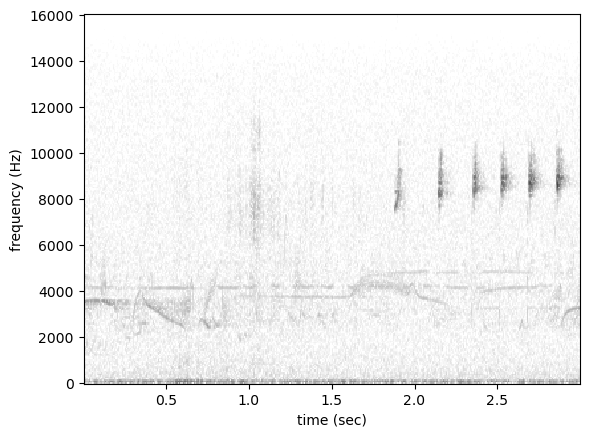

added confidence tag 5 to the dataframe.
confidence_cat
0    8227
3     238
5      69
2      36
1       1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [11]:
valid_df_verified = verify_samples(valid_df_verified, ground_truth=0.0, loss_sorted=True)

<Axes: xlabel='confidence_cat'>

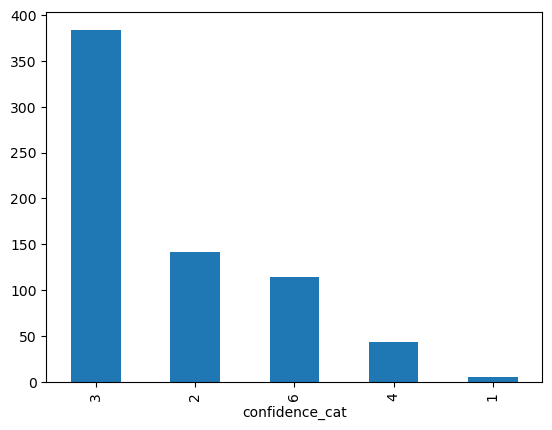

In [751]:
counts = valid_df_verified.loc[valid_df_verified.target_present==1.0].confidence_cat.value_counts()
# plot the counts and re-label the x labels with the confidence categories
counts.plot(kind='bar')

After verifying the present samples in the validation set, we are left with just over 400 present samples.

# Verify the absent class
The absent class is much larger than the present class, so we'll use a different strategy to clean the samples:
- Go through the samples with the highest loss and re-label those which actually contain the target class. 
- Take a sample of the items in the shuffled validation set equal to the number of present samples available. Verify all of these. 
- This will give us a fully checked validation set with equal numbers of samples from each class.
- Additionally we'll have gone through the top section of samples in the validation set which are most likely to have been mis-labelled. 
- Testing the model against this validation set will give a better feel for how the model will perform in production - since there is likely to be much more absent audio than present audio - these are unlikely to occur at a 50/50 ratio in any case. 

target = 0.0, prediction = 0.8399062156677246 loss = 0.8399062156677246


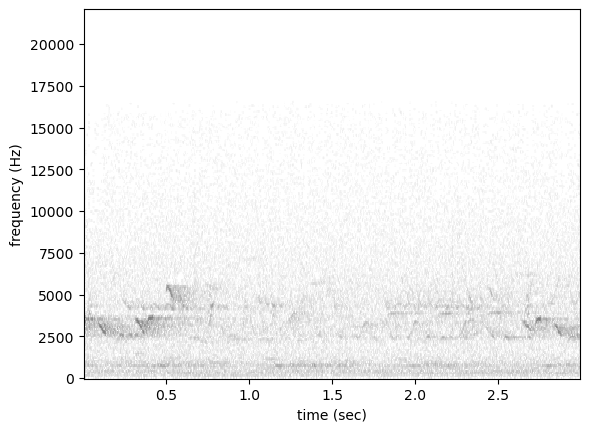

added confidence tag 3 to the dataframe.
confidence_cat
0    8227
3     238
5      69
2      36
1       1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [1120]:
valid_df_verified = verify_samples(valid_df_verified, ground_truth=0.0, loss_sorted=True)

In [10]:
# # Re-label mistaken sample here
# valid_df_verified.loc[valid_df_verified.predicted == 0.9979363679885864, 'confidence_cat'] = 0


In [12]:
# plot the counts of verification work on the absent class. 
valid_df_verified.loc[valid_df_verified.target_present==0.0].confidence_cat.value_counts()

confidence_cat
0    8227
3     238
5      69
2      36
1       1
Name: count, dtype: int64

In [1142]:
# Build a balanced validaion set

n_samples_per_class = 400
# Choose all of the focal present samples
focal_present = valid_df_verified.loc[valid_df_verified.target_present==1.0].loc[valid_df_verified.confidence_cat==4]
# Choose a random sample of the remaining present samples
present = valid_df_verified.loc[valid_df_verified.target_present==1.0].loc[valid_df_verified.confidence_cat==3]
present = pd.concat([focal_present, present.sample(n=n_samples_per_class-len(focal_present))])
print(len(present))

# Choose a random sample of 500 absent samples to verify - knowing that we'll want to end up with 400 and some will be mis-labelled.
absent = valid_df_verified.loc[valid_df_verified.target_present==0.0].sample(n=n_samples_per_class + 100)


400


target = 0.0, prediction = 0.10509130358695984 loss = 0.10509130358695984


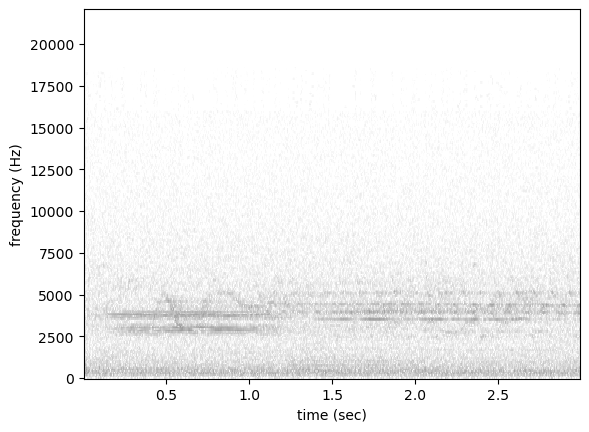

added confidence tag 3 to the dataframe.
confidence_cat
3    433
0     52
5      9
2      6
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [1569]:
absent = verify_samples(absent, ground_truth=0.0, loss_sorted=True)

# Construct a balanced validation set from equal numbers of verified samples. 

In [1571]:
absent = absent.loc[absent.confidence_cat==3].sample(n=n_samples_per_class, random_state=42)
balanced_valid_df = pd.concat([present, absent])

balanced_valid_df.target_present.value_counts()

target_present
1.0    400
0.0    400
Name: count, dtype: int64

# Save the verification work to disk

In [1572]:
valid_df_verified.to_pickle(data_path / "interim" / "valid_set" / "valid_set_verified.pkl")
balanced_valid_df.to_pickle(data_path / "interim" / "valid_set" / "balanced_valid_set_verified.pkl")

In [16]:
valid_df_verified.target_present.value_counts()

target_present
0.0    8571
1.0     687
Name: count, dtype: int64

# Concluding notes
We started out with a data set which relied entirely on human labels from wildtrax. Some of these contained errors, so we trained an initial model using this noisy data, and used it as an aid for cleaning the validation set in the following way:

1. A set of 400 verified present samples and verified 400 absent samples were saved as __balanced_valid_set_verified__

2. A larger set of 8571 absent samples and 687 present samples is available too. The present samples were all checked, and the absent samples were sorted by highest error between prediction and label (loss), then the top few hundred of these were checked, until the model predictions were below 80% and there were relatively few actual present samples. A confidence category was assigned to these so that they can be re-labelled. This dataset is saved as __valid_set_verified__
